
<h2 style="text-align:center;">Разведочный анализ данных с помощью PySpark</h2>

### Цели работы:
1. Познакомиться с понятием «большие данные» и способами их обработки;
2. Познакомиться с инструментом `Apache Spark` и возможностями, которые он предоставляет для обработки больших данных;
3. Получить навыки выполнения разведочного анализа данных использованием  `pyspark`

### Задачи работы
Выполнить разведочный анализ датасета с определением:
   * типов признаков в датасете;
   * пропущенных значений и их устранением;
   * выбросов и их устранением;
   * расчетом статистических показателей признаков (средних, квартилей и т.д.);
   * визуализацией распределения наиболее важных признаков;
   * корреляций между признаками

Датасет авиабилетов из "Expedia"

Источник: https://www.kaggle.com/datasets/dilwong/flightprices

### **1. Запуск фреймворка PySpark и загрузка данных** 

In [ ]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
import pylab 
import seaborn as sns
import scipy.stats as scipy_stats
from scipy.stats import probplot

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [ ]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row, DataFrame, SparkSession, SQLContext, functions, Window
from pyspark.sql.types import DoubleType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import skewness, lit, desc, col ,when, size, array_contains, row_number, \
isnan, udf, hour, array_min, array_max, countDistinct, median, collect_list, \
max, mean, min, stddev, monotonically_increasing_id  
from pyspark.sql.types import *

from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator

MAX_MEMORY = '15G'

# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'data/itineraries_part2Short.csv'

# Load the main data set into pyspark data frame 
df = spark.read.options(inferSchema='True', header='True', delimeter=',').csv(filename_data, mode='DROPMALFORMED')
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
print('Data overview')
df.printSchema()

Data overview
root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDeparture

### 2. Обзор датасета itineraries 

Датасет содержит информацию о ценах на полеты в одну сторону самолетами согласно Expedia на период с 16.04.2022 до 05.10.2022.

Датасет представляет собой CSV-файл, где каждая строка - купленный билет в/из следующих аэропортов: ATL, DFW, DEN, ORD, LAX, CLT, MIA, JFK, EWR, SFO, DTW, BOS, PHL, LGA, IAD, OAK.

Определения столбцов:
* legId: Идентификатор рейса.
* searchDate: Дата (ГГГГ-ММ-ДД), когда эта запись была взята из Expedia.
* flightDate: Дата (ГГГГ-ММ-ДД) полета.
* startingAirport: Трехсимвольный код аэропорта IATA для начального местоположения.
* destinationAirport: Трехсимвольный код аэропорта IATA для места прибытия.
* fareBasisCode: Код основного тарифа.
* travelDuration: Продолжительность поездки в часах и минутах.
* elapsedDays: Количество прошедших дней (обычно 0).
* isBasicEconomy: Булево значение, указывающее, предназначен ли билет для базовой экономики.
* isRefundable: Булево значение, указывающее, можно ли вернуть деньги за билет.
* isNonStop: Булево значение, указывающее, является ли рейс беспосадочным.
* baseFare: Цена билета (в USD).
* totalFare: Цена билета (в USD), включая налоги и другие сборы.
* seatsRemaining: Целое число для количества оставшихся мест.
* totalTravelDistance: Общее расстояние поездки в милях. Эти данные иногда отсутствуют.
* segmentsDepartureTimeEpochSeconds: Строка, содержащая время отправления (время Unix) для каждого этапа поездки. Записи для каждого этапа разделяются символом '||'.
* segmentsDepartureTimeRaw: Строка, содержащая время отправления (формат ISO 8601: YYYY-MM-DDThh:mm:ss.000±[hh]:00) для каждого этапа поездки. Записи для каждого из этапов разделяются символом '||'.
* segmentsArrivalTimeEpochSeconds: Строка, содержащая время прибытия (время Unix) для каждого этапа поездки. Записи для каждого этапа разделяются символом '||'.
* segmentsArrivalTimeRaw: Строка, содержащая время прибытия (формат ISO 8601: YYYY-MM-DDThh:mm:ss.000±[hh]:00) для каждого этапа поездки. Записи для каждого из этапов разделяются символом '||'.
* segmentsArrivalAirportCode: Строка, содержащая код аэропорта IATA для места прибытия для каждого этапа поездки. Записи для каждого этапа разделяются символом '||'.
* segmentsDepartureAirportCode: Строка, содержащая код аэропорта IATA для места отправления на каждом этапе путешествия. Записи для каждого этапа разделяются символом '||'.
* segmentsAirlineName: Строка, содержащая название авиакомпании, обслуживающей каждый этап путешествия. Записи для каждого этапа разделяются символом '||'.
* segmentsAirlineCode: Строка, содержащая двухбуквенный код авиакомпании, обслуживающей каждый этап путешествия. Записи для каждого этапа разделяются символом '||'.
* segmentsEquipmentDescription: Строка, содержащая тип самолета, используемого на каждом этапе путешествия (например, "Airbus A321" или "Boeing 737-800"). Записи для каждого из этапов разделяются символом '||'.
* segmentsDurationInSeconds: Строка, содержащая продолжительность полета (в секундах) для каждого этапа путешествия. Записи для каждого этапа разделяются символом '||'.
*  segmentsDistance: Строка, содержащая пройденное расстояние (в милях) для каждого этапа поездки. Записи для каждого этапа разделяются символом '||'.
*  segmentsCabinCode: Строка, содержащая код салона для каждого этапа поездки (например, "coach"). Записи для каждого этапа разделяются символом '||'.

In [ ]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDeparture

,Column Name,Data type
0,legId,string
1,searchDate,date
2,flightDate,date
3,startingAirport,string
4,destinationAirport,string
5,fareBasisCode,string
6,travelDuration,string
7,elapsedDays,int
8,isBasicEconomy,boolean
9,isRefundable,boolean


In [ ]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,legId,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,baseFare,totalFare,seatsRemaining,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,count,999999,999999,999999,999999,999999,999999,999999,999999,999999,...,999999,999999,999999,999999,999999,999999,981025,999999,999999,999999
1,mean,1.2609181383150992E30,None,None,None,None,0.14611514611514612,308.1933982233924,356.7525630728056,5.702068702068702,...,1.652769507668754E9,None,None,None,None,None,None,10968.940811161741,1088.042087722686,None
2,stddev,0.0,None,None,None,None,0.35322745499841246,217.36452680367097,233.45832586884347,2.940687900095263,...,1405601.4371413807,None,None,None,None,None,None,5151.56854151199,722.1398291469872,None
3,min,00000115f8d6a14453bcd1bbc90fbd0b,ATL,ATL,A0ATZNFC,P1DT12M,0,5.1,23.97,0,...,1650445920,2022-04-20T04:29:00.000-06:00,ABE||DTW,ATL,Alaska Airlines,4B||4B||AA,AIRBUS INDUSTRIE A320 SHARKLETS,10020,1003||995,business
4,max,ffffe7aa2c35e8bf4d567cc544ce006d,SFO,SFO,ZVAZZNN3,PT9H9M,2,4407.44,4752.6,10,...,1655555820||1655578620,2022-06-18T08:37:00.000-04:00||2022-06-18T14:5...,XNA||ORD,TTN||RDU,United||United||United||United,UA||UA||UA||UA,||||Embraer 175 (Enhanced Winglets),9960||9960,None||None||None,premium coach||premium coach||coach


There are total 999999 row, Let print first 2 data rows:


,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,b3972452c388f0f3222177e0fc084f47,2022-04-18,2022-05-30,ORD,SFO,YA2AA,PT6H23M,0,False,False,...,1653932760||1653940140,2022-05-30T10:46:00.000-07:00||2022-05-30T12:4...,SNA||SFO,ORD||SNA,Alaska Airlines||Alaska Airlines,AS||AS,Boeing 737 MAX 8||Embraer 175,15600||5040,1726||373,coach||coach
1,143b066f4e707986872683942d0d0025,2022-04-18,2022-05-30,PHL,ATL,T21NXS2,PT2H11M,0,False,False,...,1653945780,2022-05-30T17:23:00.000-04:00,ATL,TTN,Frontier Airlines,F9,None,7860,701,coach


### 3. Обнаружение пропущенных значений и аномальных нулей

После получения первого представления о колонках, в первую очередь необходимо убедиться, имеет ли датасет какие-либо пропущенные и аномальные нулевые значения.
- Для строковых колонок проверим на `None` и `null`;
- Для числовых колонок, допускающих значения ноль, проверим на `None` и `NaN`;
- Для числовых колонок, недопускающих значения ноль, проверим на нули, `None` и `NaN`;
- Для булевых колонок проверим на `None` и `null`;
- Для колонок с датами проверим на `None` и `null`.

In [ ]:
string_columns = [
    'legId', 'startingAirport', 'destinationAirport', 'fareBasisCode', 'travelDuration', 
    'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 
    'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 
    'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription', 'segmentsDurationInSeconds', 
    'segmentsDistance', 'segmentsCabinCode'
]

numeric_with_zeroes_columns = ['elapsedDays', 'seatsRemaining']
numeric_without_zeroes_columns = ['baseFare', 'totalFare', 'totalTravelDistance']

boolean_columns = ['isBasicEconomy', 'isRefundable', 'isNonStop']

date_columns = ['searchDate', 'flightDate']

missing_values = {} 

for index, column in enumerate(df.columns):
    if column in string_columns: # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_with_zeroes_columns: # check None, NaN and Null
        missing_count = df.filter(col(column) == None | isnan(col(column)) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_without_zeroes_columns:  # check zeroes, None, NaN and Null
        missing_count = df.filter(col(column).isin([0,None]) | isnan(col(column)) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in boolean_columns:  # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in date_columns:  # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})

missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

columns_with_missing_values = []
for column in missing_df:
    if missing_df[column].values[0] != 0:
        columns_with_missing_values.append(column)

missing_df[columns_with_missing_values]


,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,18974,0,0,0


,totalTravelDistance,segmentsEquipmentDescription
0,59338,18974


In [ ]:
mean_value = df.agg(mean(df['totalTravelDistance'])).collect()[0][0]
mean_value

1575.7580871323462

In [ ]:
df_fill = df.withColumn('totalTravelDistanceWasNull', when(df['totalTravelDistance'].isNull(), 1).otherwise(0))

In [ ]:
df_fill=df_fill.na.fill(value=mean_value,subset=["totalTravelDistance"])
df_fill.select('totalTravelDistance','totalTravelDistanceWasNull').limit(10).toPandas()

,totalTravelDistance,totalTravelDistanceWasNull
0,2099,0
1,701,0
2,1575,1
3,667,0
4,667,0
5,1259,0
6,695,0
7,1259,0
8,667,0
9,667,0


In [ ]:
print(f'Number of rows before deleting na values: {df.count()}')
df = df.na.drop(subset=columns_with_missing_values)
print(f'Number of rows after deleting na values: {df.count()}')

Number of rows before deleting na values: 999999
Number of rows after deleting na values: 924264


In [ ]:
print(f'Number of rows before deleting na values: {df_fill.count()}')
df_fill = df_fill.na.drop(subset=columns_with_missing_values)
print(f'Number of rows after deleting na values: {df_fill.count()}')

Number of rows before deleting na values: 999999
Number of rows after deleting na values: 981025


### 4. Определение выбросов и удаление выбросов

Для удаления выбросов их необходимо определить.

Воспользуемся Метод Z-оценки

Источники: 
* https://medium.com/nuances-of-programming/%D0%BA%D0%B0%D0%BA-%D0%BE%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B8%D1%82%D1%8C-%D0%B2%D1%8B%D0%B1%D1%80%D0%BE%D1%81%D1%8B-%D0%B2-%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82%D0%B5-%D0%BF%D0%BE-%D0%B8%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8E-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-44930b6853f
* https://www.codecamp.ru/blog/find-outliers-with-iqr/?ysclid=lovh2o8zyp383896164

Метод  Z-оценки

Z-оценка, или “стандартная оценка”, — это статистическая мера, которая показывает, на сколько стандартных отклонений наблюдаемая точка удалена от среднего значения. 
При использовании этого метода необходимо определить порог: если точка данных имеет значение, превышающее пороговое, то она является выбросом.

Вычисляем Z следующим образом:
    z = (X - μ) / σ
В этой формуле :
- X — значение точки данныхх;
- μ - среднее значения;
- σ - стандартное отклонен

    Метод Z-оценки имеет несколько недостатков:
* Его можно использовать только с одномерными данными (один столбец датафреймов, массивов, списков и т. д.);
* Он должен использоваться только с нормально распределенными данными;
* Исследователю придется определить порог, зависящий данных.

In [ ]:
def z_estimation(df, column):
    #z_values_column_name = 'z'
    #row_idx_column_name = 'row_idx'
    
    data = np.array(df.select(collect_list(column)).first()[0])
    z = np.abs(scipy_stats.zscore(data))
    
    mean_value = df.agg(mean(column).alias(f'mean_{column}')).collect()[0][f'mean_{column}']
    stddev_value = df.agg(stddev(column).alias(f'stddev_{column}')).collect()[0][f'stddev_{column}']
    

    lower_bound = mean_value - 3 * stddev_value
    upper_bound = mean_value + 3 * stddev_value
    
    filtered_df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    return filtered_df

In [ ]:
df_z = df
for column in numeric_with_zeroes_columns:
    df_z = z_estimation(df_z,column)
for column in numeric_without_zeroes_columns:
    df_z = z_estimation(df_z,column)

In [ ]:
df.count()
df_z.count()

924264

905835

### 5. Расчет статистических показателей признаков

Рассчитаем следующие показатели:
- Минимальное ,cреднее и максимальное значения;
- Среднеквадратичное отклонение;
- Квартили;
- Коэффициент асимметрии;

In [ ]:
def calculate_min_mean_max_statistic_indicators(df, column):
    min_value = df.agg(min(column).alias(f'min_{column}')).collect()[0][f'min_{column}']
    mean_value = df.agg(mean(column).alias(f'mean_{column}')).collect()[0][f'mean_{column}']
    max_value = df.agg(max(column).alias(f'max_{column}')).collect()[0][f'max_{column}']
    return (min_value, mean_value, max_value)

In [ ]:
def calculate_stdev(df, column):
    stddev_value = df.agg(stddev(column).alias(f'stddev_{column}')).collect()[0][f'stddev_{column}']
    return stddev_value

In [ ]:
def calculate_quartiles(df, column):
    q1, median, q3 = df.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
    return q1, median, q3

In [ ]:
def calculate_skewness(df, column):
    skewness_value = df.select(skewness(column).alias(f'skewness_{column}')).collect()[0][f'skewness_{column}']
    return  skewness_value

In [ ]:
def calculate_statistical_indicators(df, column):
    min_value, mean_value, max_value =calculate_min_mean_max_statistic_indicators(df, column)
    stddev_value = calculate_stdev(df, column)
    q1, median, q3 = calculate_quartiles(df, column)
    skewness = calculate_skewness(df, column)
    return  (min_value, mean_value, max_value, stddev_value, q1, median, q3,skewness)

In [ ]:
statistical_indicators = {}

for column in numeric_with_zeroes_columns:
    statistical_indicators[column] = calculate_statistical_indicators(df_z, column)

for column in numeric_without_zeroes_columns:
    statistical_indicators[column] = calculate_statistical_indicators(df_z, column)

for key, value in statistical_indicators.items():
    print(f"""
        Column: {key}
          -- Min: {value[0]}
          -- Mean: {value[1]}
          -- Max: {value[2]}
          -- Stddev: {value[3]}
          -- q1: {value[4]}
          -- q2(median): {value[5]}
          -- q3: {value[6]}
          -- skewness: {value[7]}
        """)


        Column: elapsedDays
          -- Min: 0
          -- Mean: 0.1403445439842797
          -- Max: 1
          -- Stddev: 0.34734433369214374
          -- q1: 0.0
          -- q2(median): 0.0
          -- q3: 0.0
          -- skewness: 2.07088827800575
        

        Column: seatsRemaining
          -- Min: 1
          -- Mean: 6.069375769317812
          -- Max: 10
          -- Stddev: 2.6542012706121234
          -- q1: 4.0
          -- q2(median): 7.0
          -- q3: 9.0
          -- skewness: -0.5853533176016547
        

        Column: baseFare
          -- Min: 8.72
          -- Mean: 298.76897745174426
          -- Max: 785.12
          -- Stddev: 152.1682138657374
          -- q1: 172.09
          -- q2(median): 278.14
          -- q3: 399.07
          -- skewness: 0.5518965647245804
        

        Column: totalFare
          -- Min: 23.97
          -- Mean: 343.2703267484361
          -- Max: 864.3
          -- Stddev: 165.89540640265406
          -- q1: 206.1
  

### 6. Визуализацией распределения наиболее важных признаков

In [ ]:
def plot_histogram(df, column):

    data = df.select(collect_list(column)).first()[0]
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins='auto', color='blue')

    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    
    plt.show()

In [ ]:
def plot_boxplot(df, column):
  
    data = df.select(collect_list(column)).first()[0]
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, vert=False)  # vert=False для горизонтального ящика

    plt.title(f"Box plot of '{column}'")
    plt.xlabel(column)
    plt.show()

In [ ]:
def pie_chart(df, column):
    
    pandas_df = df.groupby(column).count().toPandas()
    pandas_df = pandas_df.set_index(pandas_df.columns[0])
    fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect='equal'), dpi=120)

    data = pandas_df['count']
    categories = pandas_df.index

    plt.pie(data, labels = categories, autopct="%1.1f%%")
    ax.set_title(f"Pie Chart '{column}'")
    plt.show()

Column: elapsedDays


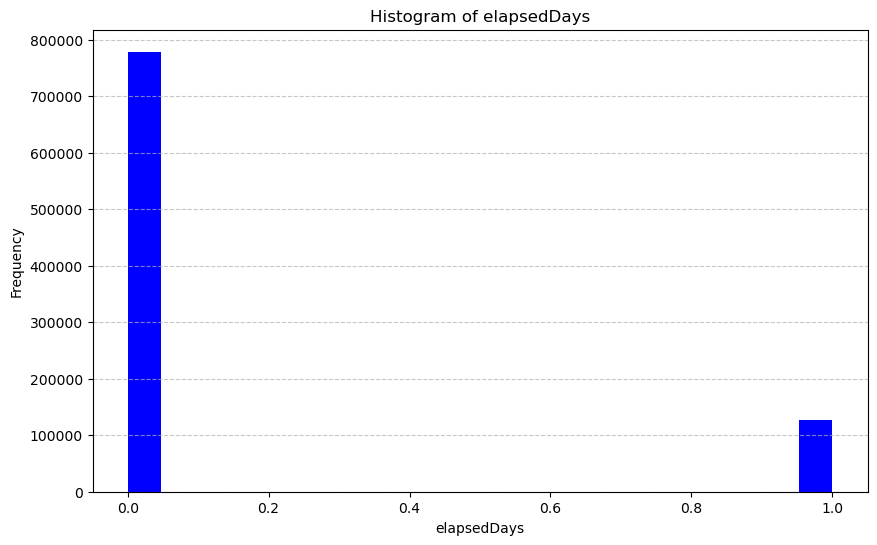

Column: seatsRemaining


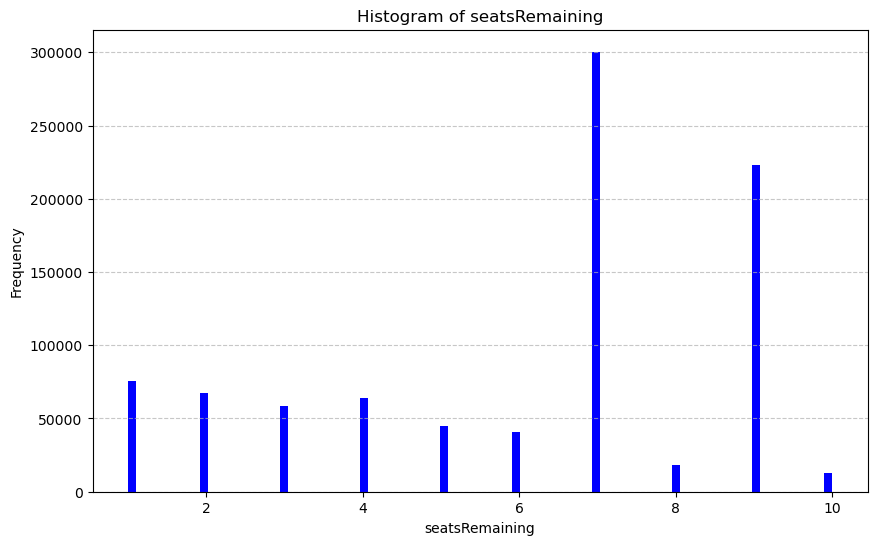

Column: baseFare


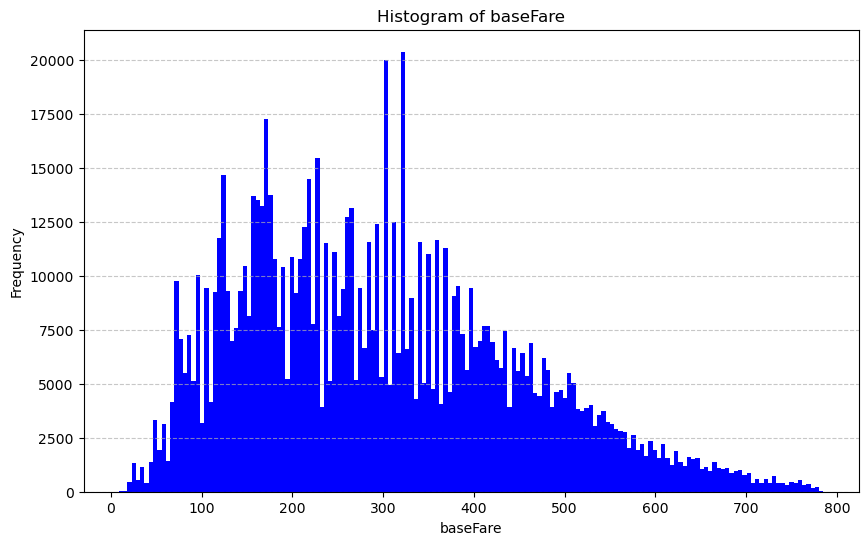

Column: totalFare


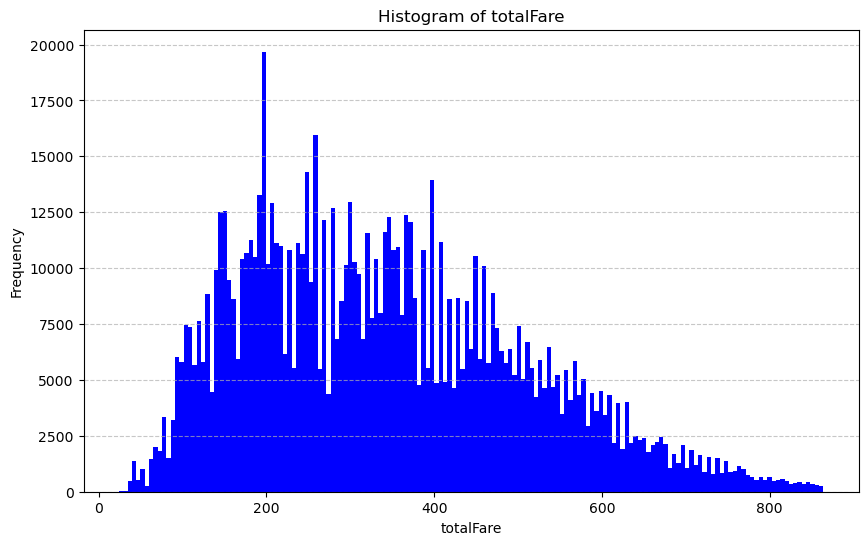

Column: totalTravelDistance


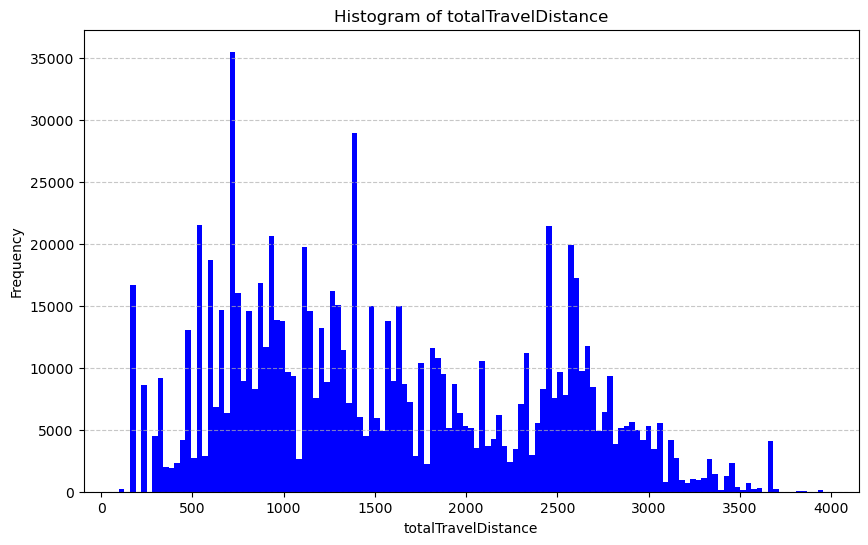

In [ ]:
for column in numeric_with_zeroes_columns:
    print(f'Column: {column}')
    plot_histogram(df_z, column)

for column in numeric_without_zeroes_columns:
    print(f'Column: {column}')
    plot_histogram(df_z, column)

Column: elapsedDays


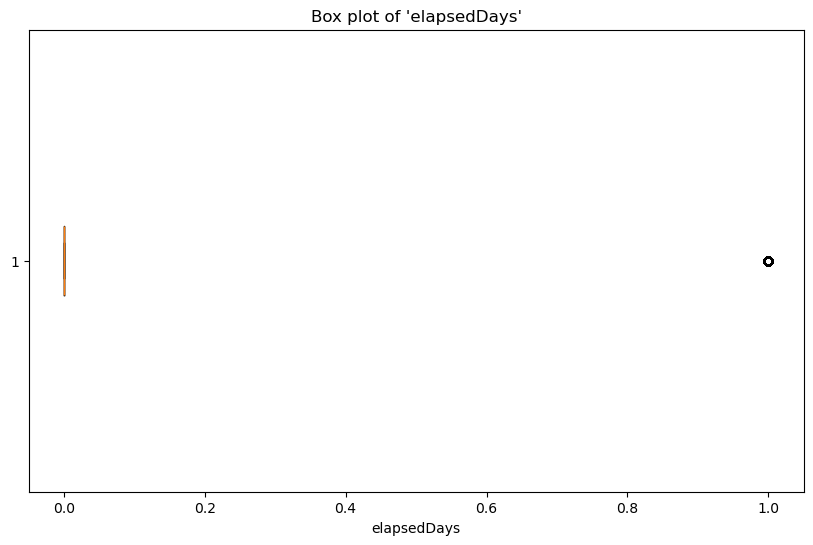

Column: seatsRemaining


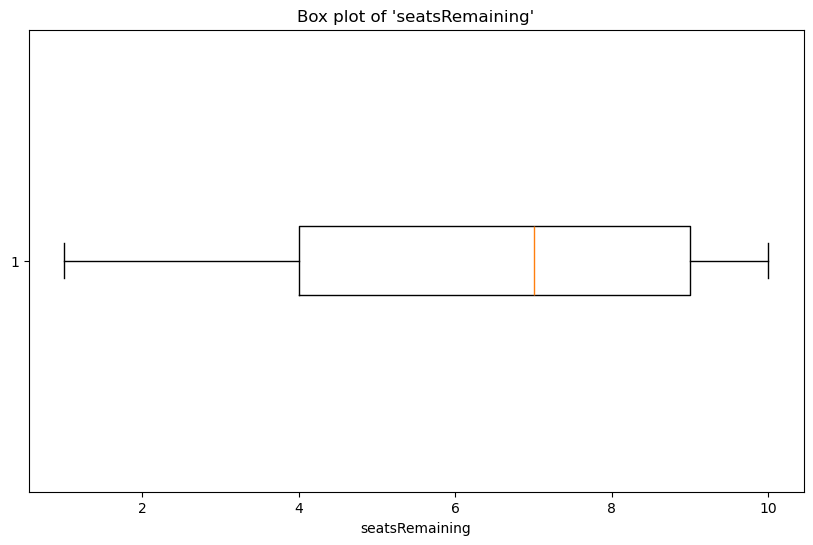

Column: baseFare


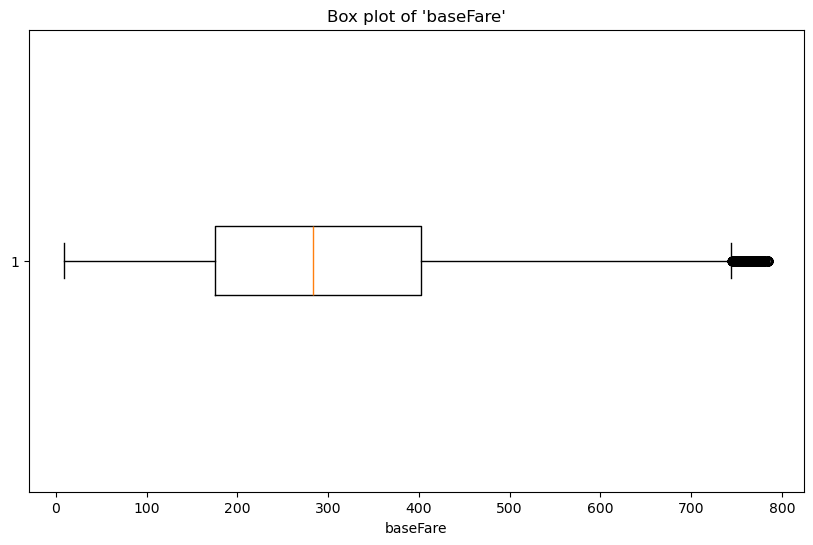

Column: totalFare


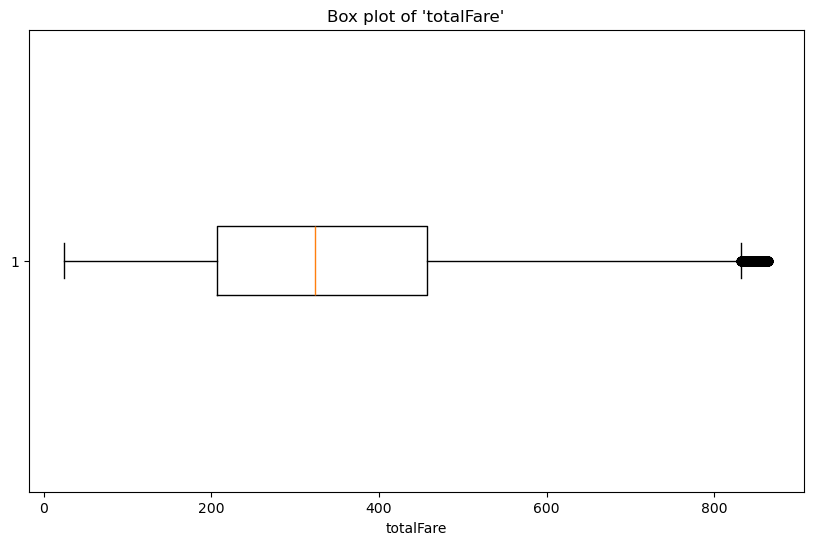

Column: totalTravelDistance


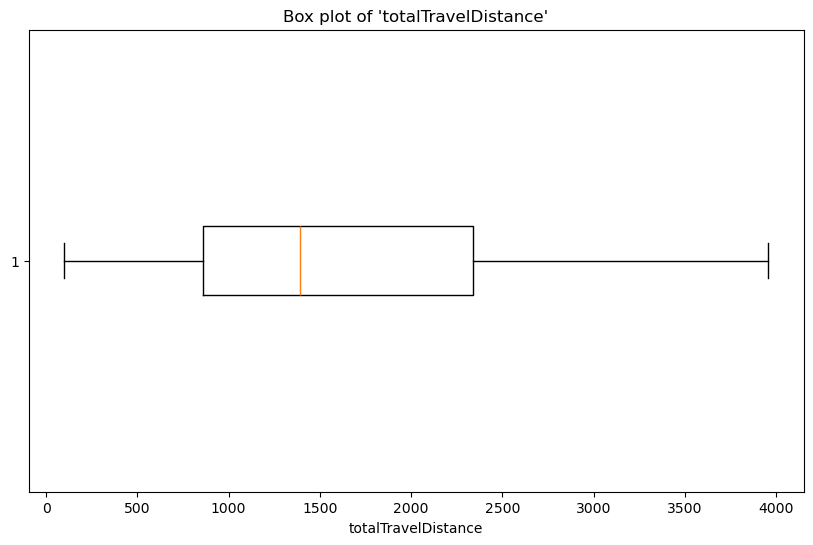

In [ ]:
for column in numeric_with_zeroes_columns:
    print(f'Column: {column}')
    plot_boxplot(df_z, column)

for column in numeric_without_zeroes_columns:
    print(f'Column: {column}')
    plot_boxplot(df_z, column)

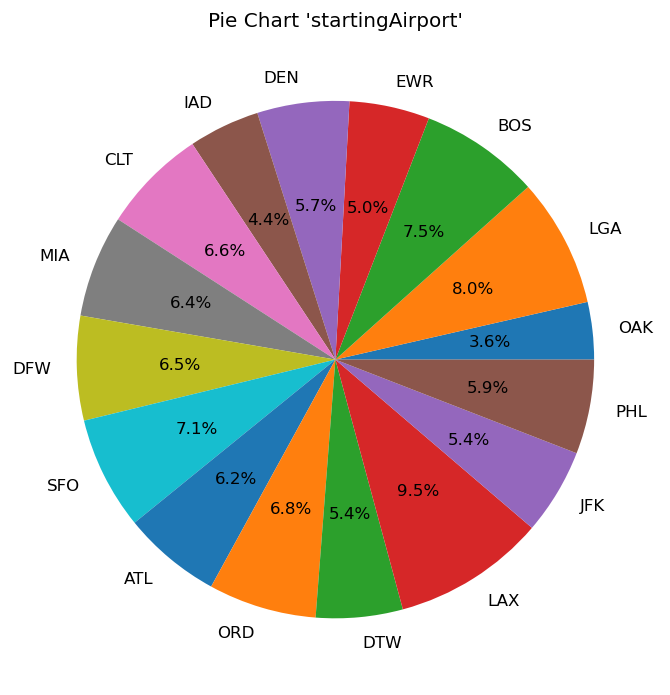

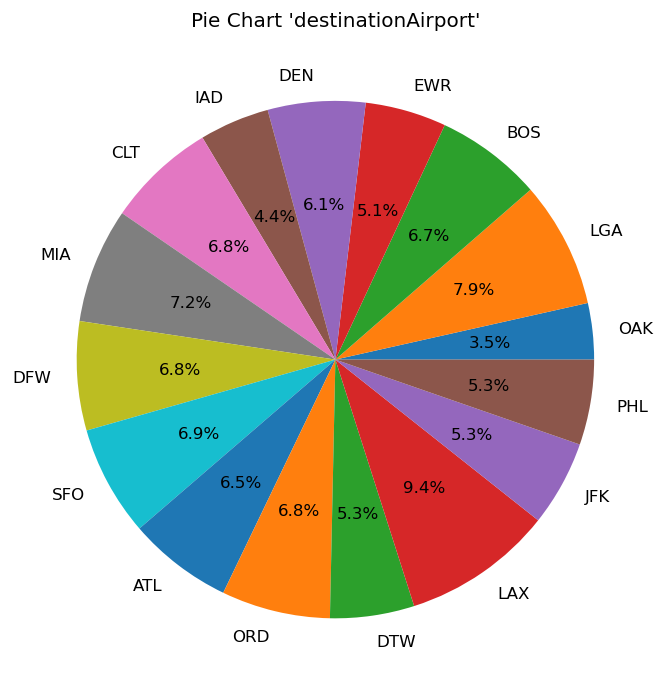

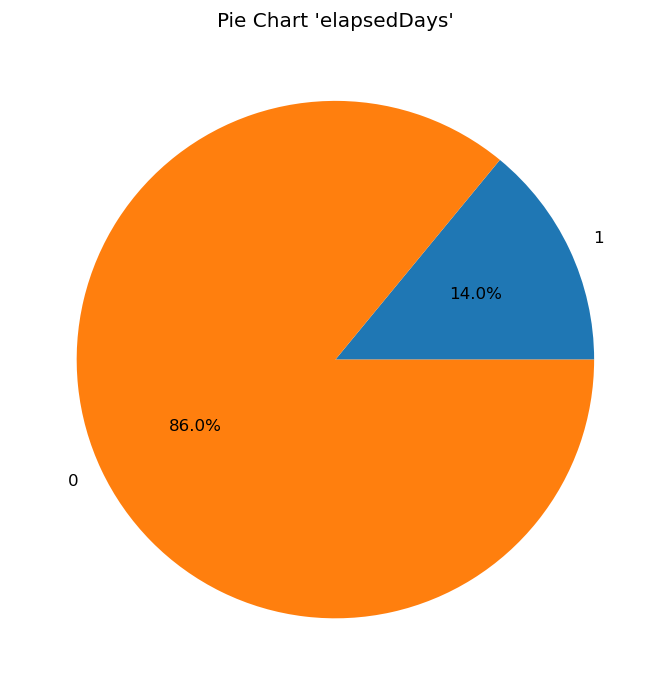

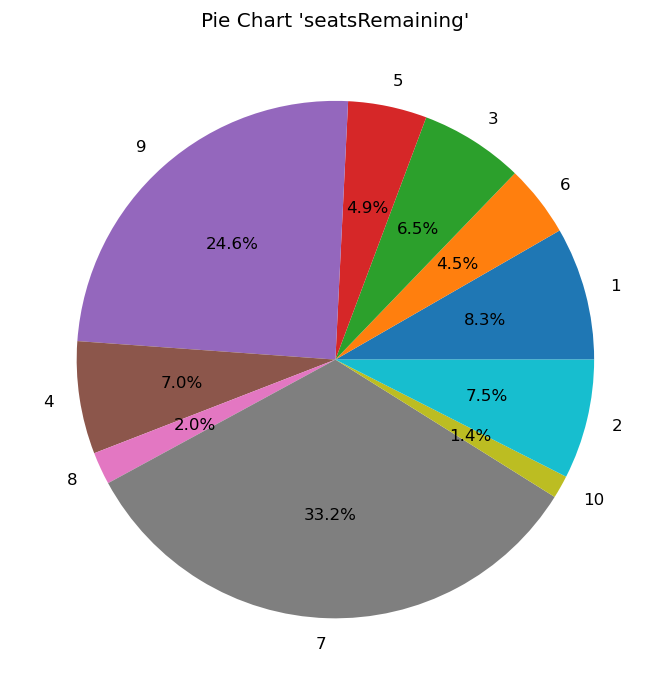

In [ ]:
pie_chart(df_z, 'startingAirport')
pie_chart(df_z, 'destinationAirport')
pie_chart(df_z, 'elapsedDays')
pie_chart(df_z, 'seatsRemaining')

### 7. Корреляций между признаками

<Figure size 1600x500 with 0 Axes>

<Axes: >

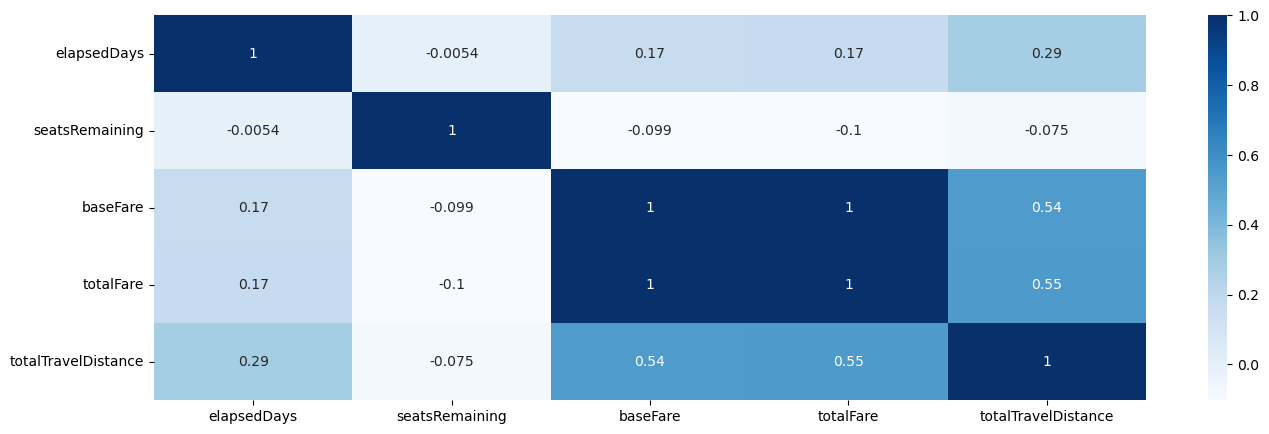

In [ ]:
vector_col = 'corr_features'
numeric_columns = numeric_with_zeroes_columns + numeric_without_zeroes_columns

assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_col)
df_vector = assembler.transform(df_z).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=numeric_columns, index=numeric_columns) 

plt.figure(figsize=(16,5))  
sns.heatmap(
    corr_matrix_df, 
    xticklabels=corr_matrix_df.columns.values,
    yticklabels=corr_matrix_df.columns.values,  
    cmap='Blues', 
    annot=True
)

Из корреляционной матрицы видно , что baseFare и totalFare демонстрируют тесную положительную взаимосвязь, поскольку цена билета всегда включает одну и ту же сумму налогов.


<h2 style="font-size:120%;">Машинное обучение на больших данных</h2>

# Линейная регрессия
## Подготовка данных

In [ ]:
from pyspark.sql.functions import col

In [ ]:

data_subset = df_z.select(
    'startingAirport',
    'destinationAirport',
    'elapsedDays',
    col('isBasicEconomy').cast('Int').alias('isBasicEconomy'),
    col('isRefundable').cast('Int').alias('isRefundable'),
    col('isNonStop').cast('Int').alias('isNonStop'),
    'baseFare',
    'totalFare',
    col('totalTravelDistance').alias('label')
)
data_subset.show(10)

+---------------+------------------+-----------+--------------+------------+---------+--------+---------+-----+
|startingAirport|destinationAirport|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|label|
+---------------+------------------+-----------+--------------+------------+---------+--------+---------+-----+
|            PHL|               ATL|          0|             0|           0|        1|   71.98|    91.98|  667|
|            PHL|               ATL|          1|             0|           0|        0|   84.08|   119.59| 1259|
|            PHL|               ATL|          0|             0|           0|        0|   84.08|   119.59|  695|
|            PHL|               ATL|          1|             0|           0|        0|   84.08|   119.59| 1259|
|            PHL|               ATL|          0|             0|           0|        1|   110.7|    133.6|  667|
|            PHL|               ATL|          0|             0|           0|        1|   110.7|    133.6

In [ ]:
strIdx = StringIndexer(inputCols = ['startingAirport', 'destinationAirport'], outputCols = ['startingAirportIdx', 'destinationAirportIdx'])
oneHotEnc = OneHotEncoder(inputCols=['startingAirportIdx', 'destinationAirportIdx'], outputCols=['startingAirportEnc', 'destinationAirportEnc'])
catVect = VectorAssembler(inputCols = ['startingAirportEnc', 'destinationAirportEnc', 'isBasicEconomy', 'isRefundable', 'isNonStop'], outputCol='catFeatures')

numVect = VectorAssembler(inputCols = ['baseFare', 'totalFare', 'elapsedDays'], outputCol='numFeatures')
minMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol='normFeatures')

featVect = VectorAssembler(inputCols=['catFeatures', 'normFeatures'], outputCol='features')
lr = LinearRegression(labelCol='label', featuresCol='features')

pipeline = Pipeline(stages=[strIdx, oneHotEnc, catVect, numVect, minMax, featVect, lr])

### Настройка параметров регрессии

In [ ]:
# Разделим данные на обучающую и тестовую выборки
splits = data_subset.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1].withColumnRenamed('label', 'trueLabel')

# Создаем сетку гиперпараметров
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.3, 0.5]) \
    .addGrid(lr.maxIter, [50, 100, 150]).build() 

# Создаем кросс-валидатор
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)
model = crossval.fit(train)

### Генерация предсказаний модели регрессии

In [ ]:
predictions = model.transform(test)
predictions = predictions.select('features', 'prediction', 'trueLabel')
predictions.show(50, truncate=False)

+-------------------------------------------------------------------+------------------+---------+
|features                                                           |prediction        |trueLabel|
+-------------------------------------------------------------------+------------------+---------+
|(36,[8,22,33,34],[1.0,1.0,0.09659969088098919,0.10666047862149394])|884.1007237067354 |947      |
|(36,[8,22,33,34],[1.0,1.0,0.15651725914477074,0.1661728130615354]) |960.9326453113794 |1823     |
|(36,[8,22,33,34],[1.0,1.0,0.16009788768675942,0.16973093903585498])|965.5190833939594 |947      |
|(36,[8,22,33,34],[1.0,1.0,0.1792890262751159,0.1887829781157403])  |990.1547974070643 |1823     |
|(36,[8,22,33,34],[1.0,1.0,0.1924523441524987,0.2018611735865672])  |1007.0226960994183|947      |
|(36,[8,22,33,34],[1.0,1.0,0.21521123132405978,0.2244713386407721]) |1036.1911650476313|947      |
|(36,[8,22,33,34],[1.0,1.0,0.21521123132405978,0.2244713386407721]) |1036.1911650476313|947      |
|(36,[8,22

### Оценка качества модели

In [ ]:
 evaluator_mse = RegressionEvaluator(labelCol='trueLabel', predictionCol='prediction', metricName="mse")
 mse = evaluator_mse.evaluate(predictions)
 print(f'Metric "RMSE" on test data: {mse:.3f}')

 evaluator_mae = RegressionEvaluator(labelCol='trueLabel', predictionCol='prediction', metricName="mae")
 mae = evaluator_mae.evaluate(predictions)
 print(f'Metric "mae" on test data: {mae:.3f}')

 evaluator_rmse = RegressionEvaluator(labelCol='trueLabel', predictionCol='prediction', metricName="rmse")
 rmse = evaluator_rmse.evaluate(predictions)
 print(f'Metric "rmse" on test data: {rmse:.3f}')

 evaluator_r2 = RegressionEvaluator(labelCol='trueLabel', predictionCol='prediction', metricName="r2")
 r2 = evaluator_r2.evaluate(predictions)
 print(f'Metric "R^2" on test data: {r2:.3f}')

Metric "RMSE" on test data: 279500.819
Metric "mae" on test data: 397.877
Metric "rmse" on test data: 528.678
Metric "R^2" on test data: 0.596


In [ ]:
# Вывод лучших параметров
best_model = model.bestModel
best_parameters = best_model.stages[-1].extractParamMap()
print("Лучшие параметры модели LinearRegression:")
for param, value in best_parameters.items():
    print(f"{param.name}: {value}")

Лучшие параметры модели LinearRegression:
aggregationDepth: 2
elasticNetParam: 0.0
epsilon: 1.35
featuresCol: features
fitIntercept: True
labelCol: label
loss: squaredError
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
regParam: 0.0
solver: auto
standardization: True
tol: 1e-06


- `aggregationDepth: 2`: процесс обучения использует двухуровневую агрегацию.
- `elasticNetParam: 0.0`:  модели используется только L2-регуляризация.
- `epsilon: 1.35`: : Параметр регуляризации, который добавляется к функции потерь во время обучения модели.
- `featuresCol: features`: Имя столбца, содержащего признаки."
- `fitIntercept: True`: Указывает, что модель должна оценить коэффициент пересечения (intercept).
- `labelCol: label`: Имя столбца, содержащего целевую переменную.
- `loss: squaredError`: Функция потерь, используемая в модели, является среднеквадратичной ошибкой.
- `maxBlockSizeInMB: 0.0`: Это параметр, влияющий на производительность обучения.
- `maxIter: 100`: Максимальное количество итераций.,`predictionCol: prediction`: Имя столбца, содержащего предсказания модели.
- `regParam: 0.0`: Этот параметр указывает на отсутствие регуляризации в модели.
- `solver: auto`: Метод решения задачи оптимизации при обучении модели выбирается автоматически.
- `sstandardization: True`: Указывает, что признаки будут стандартизированы перед обучением модели.
- `Tol: 1e-06`: минимальное значение изменения, при котором обучение модели будет становлено.
иноационном наборе."

Гиперпараметры:
- `regParam`:  Этот гиперпараметр управляет силой регуляризации в модели. Чем больше значение, тем сильнее регуляризация.
- `elasticNetParam`: Этот гиперпараметр управляет смесью между L1 и L2 регуляризацией. Значение 0 соответствует только L2 (гребневой) регуляризации, значение 1 - только L1 (лассо) регуляризации, а промежуточные значения представляют смесь обеих форм регуляризации.
  
- `maxIter`: Этот гиперпараметр определяет максимальное количество итераций, используемых для обучения модели.
- `tol`: Параметр остановки, который указывает минимальное изменение, при котором обучение будет остановлено.
- `fitIntercept`: Этот гиперпараметр определяет, следует ли оценивать коэффициент пересечения (intercept).
- `solver`: Этот гиперпараметр определяет метод решения задачи оптимизации при обучении модели.
- `aggregationDepth`: Этот гиперпараметр управляет глубиной агрегации, используемой для распределенного обучения модели.модели.ения модели.

# Градиентный бустин

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## Подготовка данных

 - 1 для рейса, который пролетел более среднего расстояния 1500 миль. 
 - 0 для рейса, который пролетел менее среднего расстояния 1500 миль.

In [ ]:
data_class = df_z.select(
    'startingAirport',
    'destinationAirport',
    'elapsedDays',
    col('isBasicEconomy').cast('Int').alias('isBasicEconomy'),
    col('isRefundable').cast('Int').alias('isRefundable'),
    col('isNonStop').cast('Int').alias('isNonStop'),
    'baseFare',
    'totalFare',
    (col('totalTravelDistance') > 1500).cast('Int').alias('label')
)
data_class.show(10)

+---------------+------------------+-----------+--------------+------------+---------+--------+---------+-----+
|startingAirport|destinationAirport|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|label|
+---------------+------------------+-----------+--------------+------------+---------+--------+---------+-----+
|            PHL|               ATL|          0|             0|           0|        1|   71.98|    91.98|    0|
|            PHL|               ATL|          1|             0|           0|        0|   84.08|   119.59|    0|
|            PHL|               ATL|          0|             0|           0|        0|   84.08|   119.59|    0|
|            PHL|               ATL|          1|             0|           0|        0|   84.08|   119.59|    0|
|            PHL|               ATL|          0|             0|           0|        1|   110.7|    133.6|    0|
|            PHL|               ATL|          0|             0|           0|        1|   110.7|    133.6

In [ ]:
strIdx = StringIndexer(inputCols = ['startingAirport', 'destinationAirport'], outputCols = ['startingAirportIdx', 'destinationAirportIdx'])
oneHotEnc = OneHotEncoder(inputCols=['startingAirportIdx', 'destinationAirportIdx'], outputCols=['startingAirportEnc', 'destinationAirportEnc'])
catVect = VectorAssembler(inputCols=['startingAirportEnc', 'destinationAirportEnc', 'isBasicEconomy', 'isRefundable', 'isNonStop'], outputCol='catFeatures')

numVect = VectorAssembler(inputCols=['baseFare', 'totalFare', 'elapsedDays'], outputCol='numFeatures')
minMax = MinMaxScaler(inputCol=numVect.getOutputCol(), outputCol='normFeatures')

featVect = VectorAssembler(inputCols=['catFeatures', 'normFeatures'], outputCol='features')
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxDepth=4, maxBins=16)

pipeline = Pipeline(stages=[strIdx, oneHotEnc, catVect, numVect, minMax, featVect, gbt])

### Настройка параметров бинарной классификации

In [ ]:
splits = data_class.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1].withColumnRenamed('label', 'trueLabel')

positive_count = train.filter(col("label") == 1).count()
negative_count = train.filter(col("label") == 0).count()
balance_ratio = positive_count / negative_count
print("Positive to Negative Class Ratio:", balance_ratio)

Positive to Negative Class Ratio: 0.8563330176848463


In [ ]:
paramGrid = (ParamGridBuilder() \
             .addGrid(gbt.maxDepth, [2, 4, 6]) \
             .addGrid(gbt.maxBins, [8, 16, 32]) \
             .build())

crossval  = CrossValidator(
    estimator=pipeline,
    evaluator=BinaryClassificationEvaluator(),
    estimatorParamMaps=paramGrid,
    numFolds=2
)
model  = crossval.fit(train)

### Генерация предсказаний модели регрессии

In [ ]:
prediction = model.transform(test)
predictions = predictions.select('features', 'prediction', 'trueLabel')
predictions.show(50, truncate=False)

+--------------------------------------------------------------------------+----------+---------+
|features                                                                  |prediction|trueLabel|
+--------------------------------------------------------------------------+----------+---------+
|(36,[8,22,33,34],[1.0,1.0,0.12655847501287998,0.1346256827674842])        |0.0       |0        |
|(36,[8,22,33,34],[1.0,1.0,0.12655847501287998,0.13641069579807932])       |0.0       |0        |
|(36,[8,22,33,34],[1.0,1.0,0.12655847501287998,0.13641069579807932])       |0.0       |0        |
|(36,[8,22,33,34],[1.0,1.0,0.1924523441524987,0.2018611735865672])         |0.0       |0        |
|(36,[8,22,33,34],[1.0,1.0,0.1924523441524987,0.2018611735865672])         |0.0       |0        |
|(36,[8,22,33,34],[1.0,1.0,0.1924523441524987,0.2018611735865672])         |0.0       |0        |
|(36,[8,22,33,34],[1.0,1.0,0.1924523441524987,0.2018611735865672])         |0.0       |0        |
|(36,[8,22,33,34],[1

### Оценка качества модели

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol='trueLabel', rawPredictionCol='rawPrediction', metricName="areaUnderROC")
# Оценка качества модели
area_under_roc_cv = evaluator.evaluate(prediction)
print(f"Area under ROC curve (cross-validated): {area_under_roc_cv}")

# Метрики классификации
true_positives = predictions.filter("prediction = 1.0 AND label = 1").count()
true_negatives = predictions.filter("prediction = 0.0 AND label = 0").count()
false_positives = predictions.filter("prediction = 1.0 AND label = 0").count()
false_negatives = predictions.filter("prediction = 0.0 AND label = 1").count()

# Accuracy (точность)
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
print(f"Accuracy: {accuracy}")

# Precision (точность)
precision = true_positives / (true_positives + false_positives)
print(f"Precision: {precision}")

# Recall (полнота)
recall = true_positives / (true_positives + false_negatives)
print(f"Recall: {recall}")

# F1 Score (F-мера)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score}")

# Вывод матрицы ошибок (Confusion Matrix)
print("\n Confusion Matrix:")
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")

Area under ROC curve (cross-validated): 0.9587101885882141
Accuracy: 0.897660963989776
Precision: 0.9111563713645966
Recall: 0.8621634885864425
F1 Score: 0.8859831477950673

 Confusion Matrix:
True Positives: 72026
True Negatives: 90579
False Positives: 7023
False Negatives: 11515


In [ ]:
best_model = model.bestModel
print("Лучшие параметры модели:")
for param_name, param_value in best_model.stages[-1].extractParamMap().items():
    print(f"{param_name.name}: {param_value}")

Лучшие параметры модели:
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
featuresCol: features
impurity: variance
labelCol: label
leafCol: 
lossType: logistic
maxBins: 8
maxDepth: 6
maxIter: 20
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 4958893628873797646
stepSize: 0.1
subsamplingRate: 1.0
validationTol: 0.01


- `cacheNodeIds: False`: Не кешировать идентификаторы узлов.
- `checkpointInterval: 10`: Интервал между контрольными точками.
- `featureSubsetStrategy: all`: Все признаки используются при обучении каждого дерева.
- `featuresCol: features`: Имя столбца, содержащего признаки.
- `impurity: variance`: Критерий оценки каче градиентного бустингасия).
- `labelCol: label`: Имя столбца, содержащего целевую переменную.
- `max8ns: 32`: Максимальное количество корзин для категориальных признаков.
- `max6epth: 5`: Максимальная глубина каждого дерева.
- `maxIter: 20`: Максимальное количество итераций (деревьев) в градиентном бустинге.
- `minInfoGain: 0.0`: Минимальное значение информационного выигрыша для узл
- `maxMemoryInMB: 256`: Устанавливает максимальный объем памяти, который может использовать модель.
- `minInfoGain: 0.0` : Задает минимальное значение информационного прироста для разбиения узлов дерева.а дерева.
- `minInstancesPerNode: 1`: Минимальное количество экземпляров для создания узла дерева.
- `minWeightFractionPerNode: 0.0`: Минимальная доля веса суммируемого экземпляра для создания узла дерева.
- `predictionCol: prediction`: Имя столбца, содержащего предсказания модел4958893628873797646
- `seed: 42`: Зерно для случайной инициализации.
- `stepSize: 0.1`: Размер шага для оптимизации.
- `subsamplingRate: 1.0`: Доля данных, используемых для обучения каждого дерева.
- `validationTol: 0.01`: Требуемая относительная терпимость для оценки производительности на вали
ационном наборе.

### Гиперпараметры:
- `maxDepth`: Максимальная глубина каждого дерева.
- `checkpointInterval`: Это гиперпараметр, который определяет интервал (в количестве итераций) для создания контрольных точек в процессе обучения модели.
- `maxIter`: Максимальное количество итераций (деревьев) в градиентном бустинге.
- `minInfoGain`: Минимальное значение информационного выигрыша для узла дерева.
- `minInstancesPerNode`: Минимальное количество экземпляров для создания узла дерева.
- `minWeightFractionPerNode`: Минимальная доля веса суммируемого экземпляра для создания узла дерева.
- `stepSize`: Размер шага для оптимизации.
- `subsamplingRate`: Гиперпараметр, который устанавливает долю подвыборки, используемую при обучении модели.
- `validationTol`: Этот гиперпараметр устанавливает порог для остановки обучения модели при использовании валидационного набора данных.х.ации.